# Create test set

In the file `explore_data.ipynb`, I found that a token cutoff of 3000 had over 95% of all tokens and articles. I also found that a cutoff of 30% symbol tokens captures about 90% of tokens and articles. In order to have a test set that is not to onerous to produce or too poo quality to recover I am going to combine both of these metrics

In [1]:
import pandas as pd
import tiktoken
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from evaluate import load
import time  # Make sure to import the time module
import jellyfish

from openai import OpenAI

from helper_file import chunk_text_with_overlap, RateLimiter, get_model_response, find_overlap, merge_chunks

directory = './data/ncse_text_chunks'

dev_transcripts = '.data/dev_transcripts'


/home/jonno/redigitalize/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
enc = tiktoken.encoding_for_model('gpt-3.5-turbo')

#the prompt is about 72 tokens
# aka nothing compared to the overal load

len(enc.encode("""You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "{title}" a newspaper based the UK and printed in {date}. 
The text cover may be an advert or an article. 
Providing no additional commentary, please recover the text from the corrupted OCR and format the text appropriately using markdown syntax'
"""))

72

In [48]:

df_list = []

for filename in os.listdir(directory):

    file_path = os.path.join(directory, filename)

    df = pd.read_parquet(file_path)
    df = df.loc[:, ['id', 'article_type_id', 'issue_date',	'publication_id', 'page_id', 'continuation_from_id',
                    'continuation_to_id', 'content_html' ,'total_tokens', 'symbol_fract']]
    
    df = df.loc[(df['total_tokens']>=100) & (df['total_tokens']<=3000) & (df['symbol_fract']<0.3) & 
                df['continuation_from_id'].isna() & df['continuation_to_id'].isna() & (df['article_type_id']!=3), :]
    df.drop(columns=[ 'continuation_from_id', 'continuation_to_id'], inplace=True)

    df_list.append(df)
    print(file_path)  # Or perform any file operation

df = pd.concat(df_list, ignore_index=True)

./data/ncse_text_chunks/ncse_base_1.parquet
./data/ncse_text_chunks/ncse_base_6.parquet
./data/ncse_text_chunks/ncse_base_0.parquet
./data/ncse_text_chunks/ncse_base_5.parquet
./data/ncse_text_chunks/ncse_base_2.parquet
./data/ncse_text_chunks/ncse_base_4.parquet
./data/ncse_text_chunks/ncse_base_3.parquet


In [53]:
periodicals_page_df

,id,page_number
0,170269,6
1,79360,15
2,81343,6
3,81344,7
4,81345,8
...,...,...
97694,160863,11
97695,160864,12
97696,160870,6
97697,160871,7


In [52]:
#Load the page number information. this is useful for transcription
periodicals_page_df = pd.read_parquet('./data/periodicals_page.parquet').rename(columns={'number':'page_number'})
periodicals_page_df = periodicals_page_df[['id', 'page_number']]

periodicals_publication_df = pd.read_parquet('./data/periodicals_publication.parquet')

periodicals_publication_df['title'] = periodicals_publication_df['title'].str.replace(r"\s\(\d{4}\-\d{4}\)", "", regex=True)

periodicals_publication_df= periodicals_publication_df.sort_values('year_from')

periodicals_publication_df

,id,abbreviation,slug,title,description,ordering,title_image,year_from,year_to,issue_count,page_count,article_count,headnotes_url,weekly
5,22,MRUC,mruc,Monthly Repository and Unitarian Chronicle,,1806,monthly-respository.jpg,1806,1837,487,26783,51202,/headnotes/mrp.html,False
0,27,NS,ns,Northern Star,,1837,northern-star.jpg,1837,1852,2201,17853,230596,/headnotes/nss.html,True
1,20,L,l,Leader,,1850,leader.jpg,1850,1860,1011,24456,162431,/headnotes/ldr.html,True
4,24,EWJ,ewj,English Woman’s Journal,,1858,english-womens-journal.jpg,1858,1864,91,5663,8061,/headnotes/ewj.html,False
2,19,T,t,Tomahawk,,1867,tomahawk.jpg,1867,1870,188,2125,12825,/headnotes/ttw.html,True
3,26,PC,pc,Publishers’ Circular,,1880,publishers-circular.jpg,1880,1890,285,20827,56739,/headnotes/tec.html,True


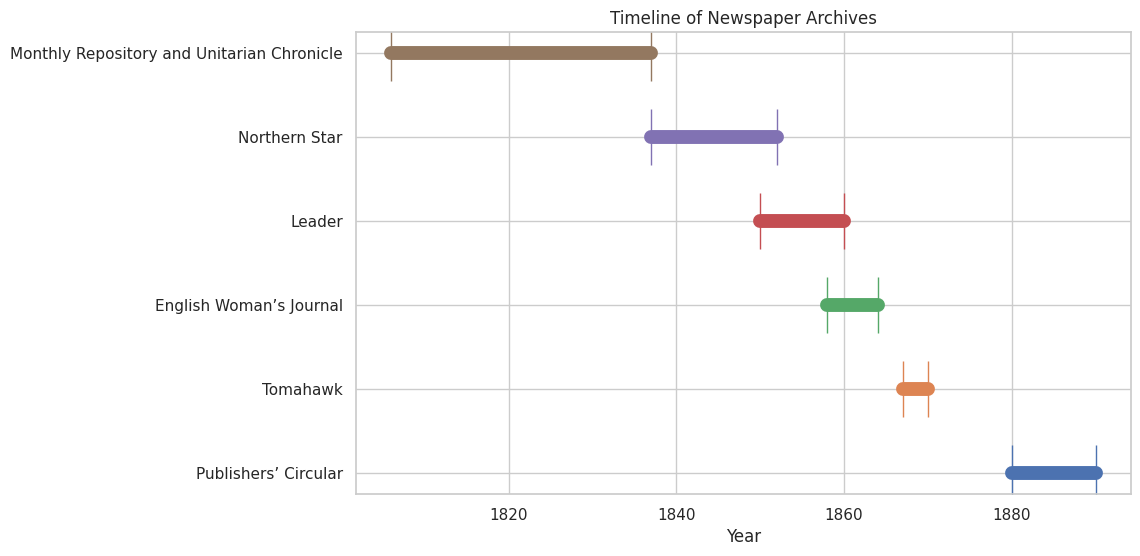

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'periodicals_publication_df' is your DataFrame
# Sort the DataFrame by 'year_from'
sorted_df = periodicals_publication_df.sort_values(by='year_from', ascending=False).reset_index(drop=True)

# Set the style
sns.set(style="whitegrid")

# Create a new figure
plt.figure(figsize=(10, 6))

# Generate each "bar" or "line" in the timeline for each name, now using sorted DataFrame
for i, row in sorted_df.iterrows():
    plt.plot([row['year_from'], row['year_to']], [i, i], marker = '|', markersize = 40, linewidth=10)

# Customizing the plot
# Use the sorted DataFrame for setting y-ticks to be the names
plt.yticks(range(len(sorted_df)), sorted_df['title'])
plt.xlabel('Year')
plt.title('Timeline of Newspaper Archives')

plt.show()


In [54]:
def sample_data(df, periodicals_publication_df, periodicals_page_df, num_articles = 20, num_adverts = 25, random_seed = 1842):

    np.random.seed(random_seed)

    # Sample 20 when article_type == 1
    sampled_df_1 = df[df['article_type_id'] == 1].groupby(['article_type_id', 'publication_id']).sample(n=num_articles, replace=False)

    # Sample 25 when article_type == 2
    sampled_df_2 = df[df['article_type_id'] == 2].groupby(['article_type_id', 'publication_id']).sample(n=num_adverts, replace=False)

    # Concatenate the sampled DataFrames
    test_data = pd.concat([sampled_df_1, sampled_df_2], ignore_index=True)


    test_data = test_data.merge(periodicals_publication_df[['id', 'title']].set_index('id'), left_on='publication_id', right_index = True)

    test_data = test_data.merge(periodicals_page_df[['id', 'page_number']].set_index('id'), left_on='page_id', right_index = True)
    # Reset index
    test_data.reset_index(drop=True, inplace=True)

    return test_data


In [57]:

test_data = sample_data(df, periodicals_publication_df,  periodicals_page_df, num_articles = 20, num_adverts = 25, random_seed = 1842)


#this is tiny as I have to transcribe this myself and is just used for tuning the prompt
dev_data = sample_data(df.loc[~df['id'].isin(test_data.id),:], periodicals_publication_df,  periodicals_page_df, 
                       num_articles = 2, num_adverts = 3, random_seed = 1842)

#This is used for creating the silver label train set with the final prompt on gpt-4
train_data = sample_data(df.loc[~df['id'].isin(test_data.id.to_list() +dev_data.id.to_list()),:], 
                         periodicals_publication_df,  periodicals_page_df,num_articles = 2, num_adverts = 3, random_seed = 1842)

In [5]:
dev_data 

,Unnamed: 0,id,article_type_id,issue_date,publication_id,page_id,content_html,total_tokens,symbol_fract,title,page_number,gpt4_response,gpt35_response
0,0,798326,1,1867-10-19,19,160077,"Second Edition , now published , price 6 d ., ...",120,0.200000,Tomahawk,10,"```\nSecond Edition, now published, price 6d.,...","**Second Edition, now published, price 6d., po..."
1,1,790721,1,1869-06-26,19,158915,"Convocation We are always , on their glad legs...",949,0.077977,Tomahawk,4,Convocation\n\nWe are always on their glad leg...,# Convocation\n\nWe are always glad to see our...
2,2,798803,2,1867-11-23,19,160147,PEPSINE DE BOUDAULT . Taken h dyspeptics at ea...,200,0.060000,Tomahawk,12,```\nPEPSINE DE BOUDAULT. Taken by dyspeptics ...,# Advertisement\n\n**PEPSINE DE BOUDAULT** \n...
3,3,791729,2,1869-07-03,19,159069,"% & lt & kg Uxitiitm , $ ct . TOWN MANSIONS an...",424,0.212264,Tomahawk,2,```\nTOWN MANSIONS and MEDIUM-SIZED RESIDENCES...,# Town Mansions and Medium-Sized Residences\n\...
4,4,798076,2,1867-06-08,19,160049,"PROTECTION FROM FIRE . EXTRACT FROM ""THE TIMES...",414,0.103865,Tomahawk,10,"```\nPROTECTION FROM FIRE. EXTRACT FROM ""THE T...","# PROTECTION FROM FIRE\n\n**EXTRACT FROM ""THE ..."
5,5,435801,1,1858-10-09,20,83148,CHINA . STATK OF AFFAIRS AT CANTON . The follo...,279,0.082437,Leader,11,```\nCHINA. STATE OF AFFAIRS AT CANTON.\n\nThe...,# CHINA: STATE OF AFFAIRS AT CANTON\n\nThe fol...
6,6,576077,1,1851-11-29,20,106647,MIHOKLLANBOUS . A supplementary Charter him be...,563,0.095915,Leader,9,```\nMISCELLANEOUS. A supplementary Charter ha...,### Miscellaneous\n\nA supplementary Charter h...
7,7,458253,2,1859-05-14,20,86218,"This Day , in Three Vols ., Cro-vro 8 vo ., cl...",159,0.276730,Leader,28,"This Day, in Three Vols., Crown 8vo., cloth, p...","# This Day, in Three Vols., Crown 8vo., cloth,..."
8,8,586049,2,1855-04-07,20,107959,^ XBTER HALL .- ^ SIE HENRY ^ BISHOP . - < JLl...,749,0.237650,Leader,22,### EXETER HALL - SIR HENRY BISHOP\n\nMr. MITC...,# Exeter Hall - Sir Henry Bishop\n\nMr. Mitche...
9,9,457637,2,1859-01-08,20,86146,"ROYAL ENGLISH OPERA , COVENT GARDEN . ( Under ...",326,0.128834,Leader,17,"```\nROYAL ENGLISH OPERA, COVENT GARDEN.\n(Und...","# ROYAL ENGLISH OPERA, COVENT GARDEN\n\n( Unde..."


## Test set stats

The english womans journal and the Montly Repository have no adverts

In [7]:
test =test_data.drop(columns=['issue_date', 'content_html', 'publication_id', 'id']).groupby(['article_type_id', 'title']).mean().reset_index()
test.rename(columns={'total_tokens':'mean_tokens'}, inplace=True)

print(test_data['total_tokens'].sum())
test

96131


,article_type_id,title,mean_tokens,symbol_fract
0,1,English Woman’s Journal,423.35,0.097623
1,1,Leader,609.45,0.099053
2,1,Monthly Repository and Unitarian Chronicle,281.40,0.126529
3,1,Northern Star,807.10,0.114928
4,1,Publishers’ Circular,657.65,0.202161
5,1,Tomahawk,364.40,0.097152
6,2,Leader,314.04,0.132774
7,2,Northern Star,268.72,0.151832
8,2,Publishers’ Circular,514.32,0.129538
9,2,Tomahawk,233.48,0.145045


In [8]:
enc = tiktoken.encoding_for_model('gpt-3.5-turbo')

# Original text
text = """You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "{title}" a newspaper based the UK and printed in {date}. 
The text cover may be an advert or an article. 
Providing no additional commentary, please recover the text from the corrupted OCR and format the text appropriately using markdown syntax."""

# Get the encoding
encoding = enc.encode(text)

# Truncate using slicing
max_tokens = 1200000  # Replace with your desired number of tokens
truncated_encoding = encoding[:max_tokens]

# Decode the truncated encoding back to text
truncated_text = enc.decode(truncated_encoding)

print(truncated_text)

You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "{title}" a newspaper based the UK and printed in {date}. 
The text cover may be an advert or an article. 
Providing no additional commentary, please recover the text from the corrupted OCR and format the text appropriately using markdown syntax.


In [84]:


# Define a function to process each row
def process_row(row, rate_limiter, engine = "gpt-3.5-turbo"):
    title = row['title']
    date = row['issue_date']
    content = row['content_html']
    
    system_message = f"""You are an expert in recovery of poor quality OCR. The below text has been retrieved from a scanned image from "{title}" a newspaper based the UK and printed in {date}. 
The text cover may be an advert or an article. 
Providing no additional commentary, please recover the text from the corrupted OCR and format the text appropriately using markdown syntax'
"""
    response = get_model_response(content, system_message, rate_limiter, engine=engine).choices[0].message.content
    return response


In [82]:
# Define a function to save text files for each row
def save_text_files(row, folder = './data/test_data'):
    # Create a directory for the current row
    
    folder_name = f"{folder}/{row.title}_{row.issue_date}_type_{row.article_type_id}_id_{row.id}"
    os.makedirs(folder_name, exist_ok=True)
    
    # Save text file for the first column
    with open(os.path.join(folder_name, 'raw_ocr.txt'), 'w') as file:
        file.write(row['content_html'])
    
    # Save text file for the second column
    with open(os.path.join(folder_name, 'recovered_ocr.txt'), 'w') as file:
        file.write(row['gpt_response'])

In [11]:


if os.path.isfile('./data/test_data_with_gpt4.csv'):
    # Load the DataFrame from the existing file
    test_data = pd.read_csv('./data/test_data_with_gpt4.csv')
else:
    # Instantiate rate limiter
    rate_limiter = RateLimiter(50000)
    
    # Apply the function to each row and store the result in a new column
    test_data['gpt4_response'] = test_data.apply(process_row, args=(rate_limiter,"gpt-4-turbo-preview"), axis=1)
    test_data['gpt35_response'] = test_data.apply(process_row, args=(rate_limiter,"gpt-3.5-turbo-0125"), axis=1)
    
    ##
    ##   takes about 93 minutes!
    ##

    # Save the DataFrame to a CSV file
    test_data.to_csv('./data/test_data_with_gpt4.csv')

    #save the txt file structure
    test_data.apply(save_text_files, axis=1)

In [2]:
if os.path.isfile('./data/dev_data_with_gpt4.csv'):
    # Load the DataFrame from the existing file
    dev_data = pd.read_csv('./data/dev_data_with_gpt4.csv')
else:
    # Instantiate rate limiter
    rate_limiter = RateLimiter(50000)
    
    # Apply the function to each row and store the result in a new column
    dev_data['gpt4_response'] = dev_data.apply(process_row, args=(rate_limiter,"gpt-4-turbo-preview"), axis=1)
    dev_data['gpt35_response'] = dev_data.apply(process_row, args=(rate_limiter,"gpt-3.5-turbo-0125"), axis=1)
    
    ##
    ##   
    ##

    # Save the DataFrame to a CSV file
    dev_data.to_csv('./data/dev_data_with_gpt4.csv')

    #save the txt file structure
    #dev_data.apply(save_text_files, axis=1)

In [24]:
file_path = './data/dev_transcript/500952_EWJ_18630701.txt'#'./data/dev_transcript/798326_tomahawk_18671019_10.txt'

# Open the file and read its contents
with open(file_path, 'r') as file:
    contents = file.read()


wer = load("wer")
cer = load("cer")
contents


'Blanche sat by her open casement,\nHumming an air as she spinn\'d;\nEver and oft the burden came,\nBorne on the summer wind.\n\n\'Twas an olden ditty she sang,\nShe had caught from lips long dead;\nLips now attuned to other songs,\n"To other songs," she said.\n\nRound and round her spinning-wheel flew,\nSwiftly the long silken thread\nDropped from her ivory fingers,-\n"An endless task!" she said.\n\nThe sun swooned away on the mountains,\nPainting the valley in red,\nIn orange and purple the vineyards,-\n"An endless day!" she said.\n\nThe moon and the stars they glimmered,\nAs the twilight shadows fled;\nShe leans from her open casement,-\n"God only is Love!" she said.\n\nAn angel in secret is weaving,\nA death shroud with mystical thread,\nUniting the half-finished meshes:-\n"God only is Rest!" he said.\n\n"Now wipe the tears from thy cheek, Blanche!\nBelieve that they lover is dead;\nFor faithless from thee he has wandered,"-\n"God only is true!" she said.\n\n\'Twas night, and the a

In [28]:
dev_data['gpt4_response'][5]

'```\nCHINA. STATE OF AFFAIRS AT CANTON.\n\nThe following extract will be found of much interest. Curiosity-collectors who are looking to China for the means of adding to their stores, may take a seasonable hint from the writer\'s reply to an application from a friend to purchase a few Chinese rarities and send them home. Further, the extract which we give (the letter was not intended for publication) throws a very strong light upon the condition of affairs, and especially on the value and estimation of certain official personages, whose names are for obvious reasons suppressed:\n\n"Canton, August, 1858.\n\nAs to curiosities, you made your friend and myself laugh at your notion of the ease of getting them. I refer you to Wardour-street. Why, I\'m thinking even of having my tea from England. I haven\'t been into a Chinese shop three times since I have been here. One gets anything here through one\'s servants. It\'s a great deal too much trouble to do anything one isn\'t obliged to do, a

In [30]:
dev_data.gpt4_response.iat[5]

'```\nCHINA. STATE OF AFFAIRS AT CANTON.\n\nThe following extract will be found of much interest. Curiosity-collectors who are looking to China for the means of adding to their stores, may take a seasonable hint from the writer\'s reply to an application from a friend to purchase a few Chinese rarities and send them home. Further, the extract which we give (the letter was not intended for publication) throws a very strong light upon the condition of affairs, and especially on the value and estimation of certain official personages, whose names are for obvious reasons suppressed:\n\n"Canton, August, 1858.\n\nAs to curiosities, you made your friend and myself laugh at your notion of the ease of getting them. I refer you to Wardour-street. Why, I\'m thinking even of having my tea from England. I haven\'t been into a Chinese shop three times since I have been here. One gets anything here through one\'s servants. It\'s a great deal too much trouble to do anything one isn\'t obliged to do, a

In [31]:
dev_data.at[5, 'content_html'].lower()

'china . statk of affairs at canton . the following extract will be found of much interest . curiosity-collectors who are looking to china for tho means of adding to their stores , may take a seasonable hint from tho writer \' s reply to an appli - cation from a friend to purchase a few chinos o raritioa and send thorn home . further , the extract vluch wo give ( the letter was not intondod for publication ) throws a very strong light upon tho condition of affairs , and especially on tho value and estimation of certain official personages , whoso names are for obvious reasons suppressed : — " canton , august , 1858 , 41 ab to ouriosilior , you made your friou . l and mysolf laugh at your notion " of tho oaso of getting thorn . i rotor you to wardour-atroot . why , i \' m thinking ovon . of having my tea from england . i hovou \' t boon into a chifioso shop three tluioa ni \' noo i lmvo boon hero . ono \' kota anything hero through one \' s servants . its a great dual too much trouble t

## Dev tests

In [35]:
text_row = 12

raw_data_string = dev_data.at[text_row, 'content_html']

#contents = contents.lower()


wer_score = wer.compute(predictions=[raw_data_string], references=[contents])
cer_score = cer.compute(predictions=[raw_data_string], references=[contents])

leven_score = jellyfish.levenshtein_distance(raw_data_string , contents)
print(f"BASE: WER:{wer_score}, CER:{cer_score}, Lev:{leven_score}")


wer_score = wer.compute(predictions=[dev_data.gpt4_response.iat[text_row]], references=[contents])
cer_score = cer.compute(predictions=[dev_data.gpt4_response.iat[text_row]], references=[contents])

leven_score = jellyfish.levenshtein_distance(dev_data.gpt4_response.iat[text_row], contents)
print(f"GPT-4: WER:{wer_score}, CER:{cer_score}, Lev:{leven_score}")

wer_score = wer.compute(predictions=[dev_data.gpt35_response.iat[text_row]], references=[contents])
cer_score = cer.compute(predictions=[dev_data.gpt35_response.iat[text_row]], references=[contents])

leven_score = jellyfish.levenshtein_distance(dev_data.gpt35_response.iat[text_row], contents)
print(f"GPT-3.5: WER:{wer_score}, CER:{cer_score}, Lev:{leven_score}")

BASE: WER:0.9408284023668639, CER:0.2020109689213894, Lev:229
GPT-4: WER:0.378698224852071, CER:0.07586837294332724, Lev:109
GPT-3.5: WER:0.3727810650887574, CER:0.08592321755027423, Lev:126


In [30]:
len(contents)

1102

In [33]:
(jellyfish.levenshtein_distance(dev_data.gpt4_response.iat[text_row], contents))/len(contents)

(jellyfish.levenshtein_distance(dev_data.gpt4_response.iat[text_row], contents))/len(contents)

0.09891107078039928

In [32]:
(jellyfish.levenshtein_distance(raw_data_string , contents) -jellyfish.levenshtein_distance(dev_data.gpt4_response.iat[text_row], contents))/jellyfish.levenshtein_distance(raw_data_string , contents) 

0.5240174672489083

In [12]:
test_data.at[1,'content_html']

'Pall ciety Our . Mall But ar , istocr the has other a p lunged ic , day sarcastic i latel t was y , into serio referre - the comic d to most at contemp the aristocracti Tham orary es P c , olice the sohono times Court ur and by a ap gentleman pearin on g this at named oc Court asion Onion ( th was e , P olice resented has Court actuall to ) receive about y had fifty the the rewar , merit , usually given c to , these p gallant individuals who make what a thri habit ll of j f oy getti —of ng pride drunk —must and riotous have passed . Now thro , onl ug y fancy the patroniz editorial e d by ctu such m of a man the Pall . Could Mall so upon great findin an honour g the paper ever have was been editors hoped . Yet for it was even true in the nevert wildest heless chdteattx and so en the Espagne Pall Mall of has its ventured to allude to its , aristocratic , patron again . Praising gratitude him , of course ! the — Pall glorif Mall ying actuall him to y the devoted skies . thirty No , alas 

In [13]:
test_data.at[1,'gpt4_response']

'Pall Mall Gazette. But aristocracy has, of a sudden, plunged into serious comic controversy. The most sarcastic reference lately was to the aristocratic themes Police Court and a gentleman appearing at this Court named Onion was presented as having actually received about fifty pounds, the reward usually given to these gallant individuals who make a habit of getting drunk and riotous—must have passed. Now, only fancy the Pall Mall Gazette being patronized by such a man. Could so great an honour upon finding the paper ever have been hoped for by its editors? Yet it was true, nevertheless, and so the Pall Mall Gazette has ventured to allude to its aristocratic patron again. Praising him, of course!—glorifying him to the skies. No, alas, to sneer at its noble patron. It is not even grateful for being advertised at Court—and at such a Court. This is base ingratitude. "We fear the equilibrium, or perhaps the distinction, on the day in question has proved too much for its mental short of sa

In [14]:
test_data.at[1,'gpt35_response']

'**Pall Mall Gazette**\n\nOur society paper, Pall Mall Gazette, has lately plunged into a sarcastic vein. It was referred to most contemptuously as "the comic Tham" or "the aristocratic Police Court" by a contemporary paper, the Soho Times. A gentleman appearing at this Court named Onion (who was actually to receive the reward) had about fifty merit, usually given to these gallant individuals who make a habit of getting—of joy—pride drunk and riotous have passed. Now, only fancy the patronized by such an editorial man of the Pall Mall. Could the paper ever have been honoured for finding such a great patron? Yet it was true in the wildest chateaux and so even the Pall Mall of Espagne has ventured to allude to its aristocratic patron again. Praising him, of course! The Pall Mall actually glorifying him to the skies. No, alas, thirty lines to sneer at its noble patron. It is not even grateful for being advertised at Court. Does not our contemporary Court appreciate such an honour? This is

# Checking the error rate

As a simple experiment I am checking the CER and WER using gpt4 as reference and gpt3.5 and raw as the predictors. This is mostly just to get a hang of the code

In [15]:
wer = load("wer")
predictions = test_data.gpt35_response
predictions2 = test_data.content_html
references = test_data.gpt4_response
wer_score = wer.compute(predictions=predictions, references=references)
print(wer_score)

wer_score = wer.compute(predictions=predictions2, references=references)
print(wer_score)

0.32668041237113404
0.9496082474226805


## Classifying genre

In [16]:
#The below did not work well. Hwoever, supplying the list as part of the system message did

system_message = f""" You are an expert in classifying newspaper articles"""
prompt = f"""
                Read following article.
                :::
                {truncated_text}
                :::

                Now without returning anyother text, select from the list below a single entry that most represents the genre of the article you just read
                ::::
                news report
                editorial
                letter
                advert
                review
                poem/song/story
                other
                ::::
                
                """

system_message = """You will be provided with text from a newspaper. Classify the text into a single category

                The categories are
                - news report
                - editorial
                - letter
                - advert
                - review
                - poem/song/story
                - other
                """

#
# This was based on open ai prompt advice, but it doesn't work so well

system_message = """You will be provided with text from a newspaper. Classify the text into a single category

                The categories are
                - news report
                - editorial
                - letter
                - advert
                - review
                - poem/song/story
                - other
                """
prompt = f"""{truncated_text}"""

system_message = f""" You are a machine that classifies newspaper articles. Your response  is limited to a single choice from the following list
    
                    ::::
                    news report
                    editorial
                    letter
                    advert
                    review
                    poem/song/story
                    other
                    ::::
                    For example given the text "Mr Bronson died today, he was a kind man" your answer would be
                    other"""


system_message = """ You are a machine that classifies newspaper articles. Your response  is limited to choices from the following json
                        {0: 'news report',
                        1: 'editorial',
                        2: 'letter',
                        3: 'advert',
                        4: 'review',
                        5: 'poem/song/story',
                        6: 'other'}
                        you will respond using a single digit.

                    For example given the text "Mr Bronson died today, he was a kind man" your answer would be
                    6
                    
                    Alternatively given the text "The prime minster spoke at parliament today" your answer would be
                    0
                    """

In [17]:
"""
                    Read the list of article genres for newspapers
                    ::::
                    ['news report', 'editorial', 'letter', 'advert', 'review', 'poem/song/story', 'other']
                    ::::
                    Now read the article below, surrounded by 3 colons, return a single word from the list of genres that most appropriately match the text
                    :::
                    {truncated_text}
                    :::
                    """

system_message = """I wish to classify an article from a newspaper into 1 of the following classes 
['news report', 'editorial', 'letter', 'advert', 'review', 'poem/song/story', 'other']. 
The article is from {title}, a newspaper printed in England in {date}. Please respond with a single word, that word being the class of the article taken from the list.
"""


In [18]:

def classify_genre_row(row, rate_limiter, engine="gpt-3.5-turbo-0125"):
    
    enc = tiktoken.encoding_for_model(engine)
    title = row['title']
    date = row['issue_date']
    content = row['gpt4_response']
    # Truncate content to max first 500 tokens
    encoding = enc.encode(content)
    # Truncate using slicing
    max_tokens = 500  # Replace with your desired number of tokens
    truncated_encoding = encoding[:max_tokens]

    # Decode the truncated encoding back to text
    truncated_text = enc.decode(truncated_encoding)
    
    system_message = """ You are a machine that classifies newspaper articles. Your response  is limited to choices from the following json
                            {0: 'news report',
                            1: 'editorial',
                            2: 'letter',
                            3: 'advert',
                            4: 'review',
                            5: 'poem/song/story',
                            6: 'other'}
                            you will respond using a single digit.

                        For example given the text "Mr Bronson died today, he was a kind man" your answer would be
                        6
                        
                        Alternatively given the text "The prime minster spoke at parliament today" your answer would be
                        0
                        """
        
    prompt = f"""
                    Classify the following article
                    :::
                    {truncated_text}
                    :::
                    
                    """
    

    response = get_model_response(prompt, system_message, rate_limiter, engine=engine).choices[0].message.content

    return response


In [19]:

rate_limiter = RateLimiter(50000)

list_classes = []
start_time = time.time()  # Capture start time
for i, row in test_data.iterrows():
    
    temp = classify_genre_row(row, rate_limiter, engine="gpt-3.5-turbo-0125")
    list_classes.append(temp)
    
    # Print execution time every 10 iterations
    if (i + 1) % 10 == 0:  
        end_time = time.time()  # Capture end time
        print(f"Iteration {i + 1}: Function execution time: {round((end_time - start_time)/10,1)} seconds per iter")
        start_time = time.time()  # Capture start time

test_data['article_class'] = list_classes


Iteration 10: Function execution time: 0.5 seconds per iter
Iteration 20: Function execution time: 0.5 seconds per iter
Iteration 30: Function execution time: 0.7 seconds per iter
Iteration 40: Function execution time: 0.8 seconds per iter
Iteration 50: Function execution time: 0.6 seconds per iter
Iteration 60: Function execution time: 0.7 seconds per iter
Iteration 70: Function execution time: 0.6 seconds per iter
Iteration 80: Function execution time: 0.7 seconds per iter
Iteration 90: Function execution time: 0.7 seconds per iter
Iteration 100: Function execution time: 0.6 seconds per iter
Iteration 110: Function execution time: 0.6 seconds per iter
Iteration 120: Function execution time: 0.6 seconds per iter
Iteration 130: Function execution time: 0.7 seconds per iter
Iteration 140: Function execution time: 60.8 seconds per iter
Iteration 150: Function execution time: 0.6 seconds per iter
Iteration 160: Function execution time: 0.8 seconds per iter
Iteration 170: Function executio

In [27]:
test_data.groupby('article_class').size()

NameError: name 'test_data' is not defined

In [147]:
test_data

,Unnamed: 0,id,article_type_id,issue_date,publication_id,content_html,total_tokens,symbol_fract,title,gpt4_response,gpt35_response,article_topics,article_class
0,0,796586,1,1870-04-16,19,Chuck : a Comic Tale . In Three Parts . By the...,116,0.155172,Tomahawk,```\nChuck: a Comic Tale. In Three Parts. By t...,**Chuck: a Comic Tale**\n\n*In Three Parts*\n\...,[0],poem/song/story
1,1,794779,1,1870-02-19,19,"Pall ciety Our . Mall But ar , istocr the has ...",374,0.056150,Tomahawk,"Pall Mall Gazette. But aristocracy has, of a s...","**Pall Mall Gazette**\n\nOur society paper, Pa...",[7],editorial
2,2,796786,1,1870-08-27,19,( generall According y at periods to our conte...,223,0.067265,Tomahawk,According to our contemporaries of a fortnight...,According to our contemporaries of a fortnight...,[10],editorial
3,3,799950,1,1867-09-07,19,"Shadowy Praise . —Mr . Tom Taylor , apropos of...",321,0.118380,Tomahawk,"Shadowy Praise.—Mr. Tom Taylor, apropos of his...","# Shadowy Praise\n\nMr. Tom Taylor, apropos of...",[0],editorial
4,4,795213,1,1870-06-18,19,"Su i ^ Untorg OK CHARLES DICKENS , Author and ...",124,0.056452,Tomahawk,"Subject: In Memory of CHARLES DICKENS, Author ...","# Sunforged of CHARLES DICKENS, Author and Phi...","[0, 11]",poem/song/story
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,931191,2,1845-03-08,27,PR . GRANDISON'S NEltVOUS PILLS . nECOMMENDED ...,215,0.125581,Northern Star,```\nDR. GRANDISON'S NERVOUS PILLS\nRECOMMENDE...,**PR. GRANDISON'S NERVOUS PILLS**\n\n**RECOMME...,[6],advert
216,216,853954,2,1851-05-31,27,SKCRET SORfiOW ! CERTAIN HELP ! Immense succes...,292,0.164384,Northern Star,```\nSECRET SORROW! CERTAIN HELP!\nImmense suc...,**SECRET SORROW! CERTAIN HELP!**\n\nImmense su...,[6],advert
217,217,709760,2,1843-08-12,27,"Now on Sale , Price Sixpence , No . III . of a...",137,0.138686,Northern Star,"```\nNow on Sale, Price Sixpence, No. III. of ...",# Now on Sale\n\nPrice Sixpence\n\nNo. III. of...,[3],advert
218,218,822644,2,1842-09-10,27,"TO THE EDITOR 6 F THE NORTHERN STAR . Lees , n...",160,0.118750,Northern Star,"TO THE EDITOR OF THE NORTHERN STAR\n\nLees, ne...",**TO THE EDITOR OF THE NORTHERN STAR** \n*Lee...,"[1, 13]",letter


# IPTC topics

There are only 17 main topics and 130 level two topic. broadly level one topics are a detailed enough way to classify the data, although it could be argued that in certain cases a more detailed approach would be valuable. One such case is 'politics' as the 1800's UK experienced a lot of political change, and so perhaps more detail on the nature of the coverage would be valuable. However, for simplicity using top level classification is more sensible as the number of articles reporting on second level topics like "cyber warfare", or 'online and remote learning' are likely to be limited. However, given the hierarchical nature of the NewsCodes, adding detail onto relvant subsets is straight forward and can be performed when appropriate

In [59]:
import json

# Load JSON data from file
with open('./data/IPTC_NewsCodes.json', 'r') as f:
    data = json.load(f)

# Convert nested level 2 dictionary to pandas DataFrame
df = pd.DataFrame(data['conceptSet'])

df = df[['uri', 'qcode', 'prefLabel','definition', 'narrower', 'broader']]
# Now df contains your data as a pandas DataFrame
df['prefLabel'] = df['prefLabel'].apply(lambda x: x['en-GB'])
df['definition'] = df['definition'].apply(lambda x: x['en-GB'])
df['qcode2'] = df['qcode'].str.replace("medtop:", "")

df['list_length'] = df['broader'].apply(lambda x: len(x) if isinstance(x, list) else None) #all are 1 long meaning there is only 2 parent. easy to manage!

df['broader'] = df['broader'].apply(lambda x: os.path.basename(x[0]) if isinstance(x, list) and len(x) > 0 else None)


In [76]:

df.loc[df['broader'].isna()]

,uri,qcode,prefLabel,definition,narrower,broader,qcode2,list_length
0,http://cv.iptc.org/newscodes/mediatopic/01000000,medtop:01000000,"arts, culture, entertainment and media","All forms of arts, entertainment, cultural her...","[medtop:20000002, medtop:20000038, medtop:2000...",None,01000000,NaN
1,http://cv.iptc.org/newscodes/mediatopic/02000000,medtop:02000000,"crime, law and justice",The establishment and/or statement of the rule...,"[medtop:20000082, medtop:20000106, medtop:2000...",None,02000000,NaN
2,http://cv.iptc.org/newscodes/mediatopic/03000000,medtop:03000000,"disaster, accident and emergency incident",Man made or natural event resulting in loss of...,"[medtop:20000139, medtop:20000148, medtop:2000...",None,03000000,NaN
3,http://cv.iptc.org/newscodes/mediatopic/04000000,medtop:04000000,"economy, business and finance","All matters concerning the planning, productio...","[medtop:20000170, medtop:20000209, medtop:2000...",None,04000000,NaN
4,http://cv.iptc.org/newscodes/mediatopic/05000000,medtop:05000000,education,"All aspects of furthering knowledge, formally ...","[medtop:20000398, medtop:20000399, medtop:2000...",None,05000000,NaN
5,http://cv.iptc.org/newscodes/mediatopic/06000000,medtop:06000000,environment,"All aspects of protection, damage, and conditi...","[medtop:20000418, medtop:20000420, medtop:2000...",None,06000000,NaN
6,http://cv.iptc.org/newscodes/mediatopic/07000000,medtop:07000000,health,All aspects of physical and mental well-being,"[medtop:20000446, medtop:20000461, medtop:2000...",None,07000000,NaN
7,http://cv.iptc.org/newscodes/mediatopic/08000000,medtop:08000000,human interest,"Item that discusses individuals, groups, anima...","[medtop:20000497, medtop:20000498, medtop:2000...",None,08000000,NaN
8,http://cv.iptc.org/newscodes/mediatopic/09000000,medtop:09000000,labour,"Social aspects, organisations, rules and condi...","[medtop:20000509, medtop:20000521, medtop:2000...",None,09000000,NaN
9,http://cv.iptc.org/newscodes/mediatopic/10000000,medtop:10000000,lifestyle and leisure,"Activities undertaken for pleasure, relaxation...","[medtop:20000538, medtop:20000565, medtop:2000...",None,10000000,NaN


In [65]:
combined_list = sum(df.loc[df['broader'].isna(), 'narrower'], [])

# Extract unique entries
unique_entries = list(set(combined_list))

print(unique_entries)

['medtop:20000502', 'medtop:20001103', 'medtop:20000446', 'medtop:20000148', 'medtop:20000461', 'medtop:20000412', 'medtop:20000536', 'medtop:20000705', 'medtop:20000483', 'medtop:20000593', 'medtop:20000073', 'medtop:20001301', 'medtop:20001130', 'medtop:20000538', 'medtop:20001126', 'medtop:20000399', 'medtop:20000808', 'medtop:20000385', 'medtop:20000056', 'medtop:20000503', 'medtop:20000802', 'medtop:20000497', 'medtop:20000504', 'medtop:20000170', 'medtop:20000647', 'medtop:20000768', 'medtop:20000480', 'medtop:20000038', 'medtop:20000160', 'medtop:20000741', 'medtop:20000770', 'medtop:20000523', 'medtop:20000756', 'medtop:20000499', 'medtop:20000689', 'medtop:20001373', 'medtop:20000648', 'medtop:20000398', 'medtop:20000509', 'medtop:20000715', 'medtop:20000521', 'medtop:20000139', 'medtop:20001108', 'medtop:20000735', 'medtop:20000430', 'medtop:20001237', 'medtop:20000002', 'medtop:20000799', 'medtop:20000574', 'medtop:20001128', 'medtop:20000788', 'medtop:20001324', 'medtop:200

In [113]:
df2 = df.loc[df['broader'].isna()].copy().reset_index()
dictionary = {}
for index, value in df2['prefLabel'].items():
    dictionary[index] = value



{0: 'arts, culture, entertainment and media',
 1: 'crime, law and justice',
 2: 'disaster, accident and emergency incident',
 3: 'economy, business and finance',
 4: 'education',
 5: 'environment',
 6: 'health',
 7: 'human interest',
 8: 'labour',
 9: 'lifestyle and leisure',
 10: 'politics',
 11: 'religion',
 12: 'science and technology',
 13: 'society',
 14: 'sport',
 15: 'conflict, war and peace',
 16: 'weather'}

In [141]:
def classify_topics_row(row, rate_limiter, engine="gpt-3.5-turbo-0125"):
    
    enc = tiktoken.encoding_for_model(engine)
    content = row['gpt4_response']
    # Truncate content to max first 500 tokens
    encoding = enc.encode(content)
    # Truncate using slicing
    max_tokens = 500  # Replace with your desired number of tokens
    truncated_encoding = encoding[:max_tokens]

    # Decode the truncated encoding back to text
    truncated_text = enc.decode(truncated_encoding)
    
    system_message = """ You are a machine that classifies newspaper articles. Your response  is limited to choices from the following json
                        {0: 'arts, culture, entertainment and media',
                        1: 'crime, law and justice',
                        2: 'disaster, accident and emergency incident',
                        3: 'economy, business and finance',
                        4: 'education',
                        5: 'environment',
                        6: 'health',
                        7: 'human interest',
                        8: 'labour',
                        9: 'lifestyle and leisure',
                        10: 'politics',
                        11: 'religion',
                        12: 'science and technology',
                        13: 'society',
                        14: 'sport',
                        15: 'conflict, war and peace',
                        16: 'weather'}
                        you will respond using a numeric python list.

                    For example given the text "The War with spain has forced schools to close" your answer would be
                    [15,4]
                    
                    Alternatively given the text "The prime minster spoke at parliament today" your answer would be
                    [10]
                    """
    
    prompt = f"""
                    Classify the following article
                    :::
                    {truncated_text}
                    :::
                    
                    """
    

    response = get_model_response(prompt, system_message, rate_limiter, engine=engine).choices[0].message.content

    return response

In [142]:
rate_limiter = RateLimiter(50000)

list_classes = []
start_time = time.time()  # Capture start time
for i, row in test_data.iterrows():
    
    temp = classify_topics_row(row, rate_limiter, engine="gpt-3.5-turbo-0125")
    list_classes.append(temp)
    
    # Print execution time every 10 iterations
    if (i + 1) % 10 == 0:  
        end_time = time.time()  # Capture end time
        print(f"Iteration {i + 1}: Function execution time: {round((end_time - start_time)/10,1)} seconds per iter")
        print(temp)
        start_time = time.time()  # Capture start time

test_data['article_topics'] = list_classes


Iteration 10: Function execution time: 0.6 seconds per iter
[0]
Iteration 20: Function execution time: 0.6 seconds per iter
[1]
Iteration 30: Function execution time: 0.5 seconds per iter
[9]
Iteration 40: Function execution time: 2.4 seconds per iter
[9]
Iteration 50: Function execution time: 0.6 seconds per iter
[15]
Iteration 60: Function execution time: 0.6 seconds per iter
[11]
Iteration 70: Function execution time: 0.8 seconds per iter
[0]
Iteration 80: Function execution time: 0.7 seconds per iter
[3]
Iteration 90: Function execution time: 0.6 seconds per iter
[11]
Iteration 100: Function execution time: 2.2 seconds per iter
[11]
Iteration 110: Function execution time: 12.5 seconds per iter
[10]
Iteration 120: Function execution time: 0.6 seconds per iter
[4, 9]
Iteration 130: Function execution time: 0.5 seconds per iter
[0]
Iteration 140: Function execution time: 0.6 seconds per iter
[0]
Iteration 150: Function execution time: 0.6 seconds per iter
[0]
Iteration 160: Function e

In [143]:
test_data

,Unnamed: 0,id,article_type_id,issue_date,publication_id,content_html,total_tokens,symbol_fract,title,gpt4_response,gpt35_response,article_topics
0,0,796586,1,1870-04-16,19,Chuck : a Comic Tale . In Three Parts . By the...,116,0.155172,Tomahawk,```\nChuck: a Comic Tale. In Three Parts. By t...,**Chuck: a Comic Tale**\n\n*In Three Parts*\n\...,[0]
1,1,794779,1,1870-02-19,19,"Pall ciety Our . Mall But ar , istocr the has ...",374,0.056150,Tomahawk,"Pall Mall Gazette. But aristocracy has, of a s...","**Pall Mall Gazette**\n\nOur society paper, Pa...",[7]
2,2,796786,1,1870-08-27,19,( generall According y at periods to our conte...,223,0.067265,Tomahawk,According to our contemporaries of a fortnight...,According to our contemporaries of a fortnight...,[10]
3,3,799950,1,1867-09-07,19,"Shadowy Praise . —Mr . Tom Taylor , apropos of...",321,0.118380,Tomahawk,"Shadowy Praise.—Mr. Tom Taylor, apropos of his...","# Shadowy Praise\n\nMr. Tom Taylor, apropos of...",[0]
4,4,795213,1,1870-06-18,19,"Su i ^ Untorg OK CHARLES DICKENS , Author and ...",124,0.056452,Tomahawk,"Subject: In Memory of CHARLES DICKENS, Author ...","# Sunforged of CHARLES DICKENS, Author and Phi...","[0, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,931191,2,1845-03-08,27,PR . GRANDISON'S NEltVOUS PILLS . nECOMMENDED ...,215,0.125581,Northern Star,```\nDR. GRANDISON'S NERVOUS PILLS\nRECOMMENDE...,**PR. GRANDISON'S NERVOUS PILLS**\n\n**RECOMME...,[6]
216,216,853954,2,1851-05-31,27,SKCRET SORfiOW ! CERTAIN HELP ! Immense succes...,292,0.164384,Northern Star,```\nSECRET SORROW! CERTAIN HELP!\nImmense suc...,**SECRET SORROW! CERTAIN HELP!**\n\nImmense su...,[6]
217,217,709760,2,1843-08-12,27,"Now on Sale , Price Sixpence , No . III . of a...",137,0.138686,Northern Star,"```\nNow on Sale, Price Sixpence, No. III. of ...",# Now on Sale\n\nPrice Sixpence\n\nNo. III. of...,[3]
218,218,822644,2,1842-09-10,27,"TO THE EDITOR 6 F THE NORTHERN STAR . Lees , n...",160,0.118750,Northern Star,"TO THE EDITOR OF THE NORTHERN STAR\n\nLees, ne...",**TO THE EDITOR OF THE NORTHERN STAR** \n*Lee...,"[1, 13]"


# 1837 overlap



In [ ]:
df_list = []

for filename in os.listdir(directory):

    file_path = os.path.join(directory, filename)

    df = pd.read_parquet(file_path)
    df = df.loc[:, ['id', 'article_type_id', 'issue_date',	'publication_id',  'continuation_from_id', 
                    'continuation_to_id', 'content_html' ,'total_tokens', 'symbol_fract']]
    
    df = df.loc[(df['issue_date']>=pd.to_datetime('1837-01-01').date()) & 
                (df['issue_date']<=pd.to_datetime('1837-12-31').date()), :]

    df_list.append(df)
    print(file_path)  # Or perform any file operation

df = pd.concat(df_list, ignore_index=True)

./data/ncse_text_chunks/ncse_base_1.parquet
./data/ncse_text_chunks/ncse_base_6.parquet
./data/ncse_text_chunks/ncse_base_0.parquet
./data/ncse_text_chunks/ncse_base_5.parquet
./data/ncse_text_chunks/ncse_base_2.parquet
./data/ncse_text_chunks/ncse_base_4.parquet
./data/ncse_text_chunks/ncse_base_3.parquet


In [ ]:
#This shows the 1837 cannot be used to compare between these two papers

df.groupby('publication_id')['issue_date'].agg(['min', 'max'])



,min,max
publication_id,,
22,1837-01-02,1837-12-01
27,1837-12-02,1837-12-16


In [ ]:
del df

# Consider the overlap between english womans and leader

In [ ]:
df['issue_date'].iat[0]

datetime.date(1864, 8, 1)

In [ ]:
16000*10/677

236.3367799113737

In [ ]:
df_list = []

for filename in os.listdir(directory):

    file_path = os.path.join(directory, filename)

    df = pd.read_parquet(file_path)
    df = df.loc[:, ['id', 'article_type_id', 'issue_date',	'publication_id',  'continuation_from_id', 
                    'continuation_to_id', 'content_html' ,'total_tokens', 'symbol_fract']]
    
    df = df.loc[df['publication_id'].isin([20,24]) & (df['issue_date']>=pd.to_datetime('1858-01-01').date()) & 
                (df['issue_date']<=pd.to_datetime('1860-12-31').date()), :]

    df_list.append(df)
    print(file_path)  # Or perform any file operation

df = pd.concat(df_list, ignore_index=True)

./data/ncse_text_chunks/ncse_base_1.parquet
./data/ncse_text_chunks/ncse_base_6.parquet
./data/ncse_text_chunks/ncse_base_0.parquet
./data/ncse_text_chunks/ncse_base_5.parquet
./data/ncse_text_chunks/ncse_base_2.parquet
./data/ncse_text_chunks/ncse_base_4.parquet
./data/ncse_text_chunks/ncse_base_3.parquet


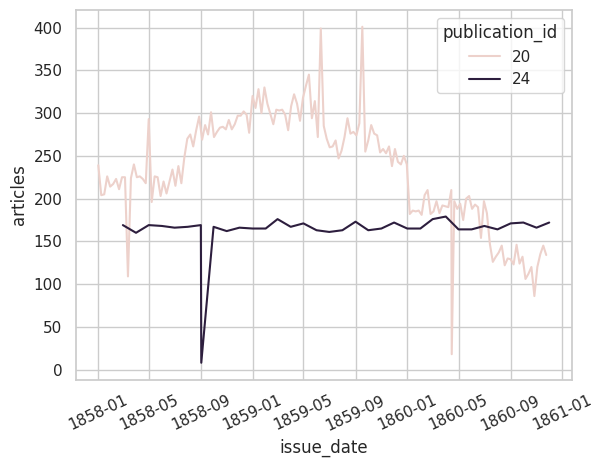

In [ ]:
df2 = df.loc[df['article_type_id']!=2].groupby(['issue_date', 'publication_id']).size().reset_index().rename(columns={0:'articles'})

sns.lineplot(data = df2, x = 'issue_date', y = 'articles', hue ='publication_id')

plt.xticks(rotation=25)  # Rotate x-axis labels to 25 degrees

plt.show()